# Sentiment Model Building

What this model should do:

    - The model should be fed text from trade_chat_v3.csv. In this case, it will ONLY be fed Game catagorized text which was done in the previous model (classification model).

## Imports

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
import time

from functions import TradeChat
tc = TradeChat()

SEED = 22

In [2]:
%store -r sm_df_token
df = sm_df_token

In [56]:
df = tc.down_sample(df, 'sentiment')
df

,date,time,text,sentiment,target,text_tokenized,joined_tokens
0,2/22/2022,8:39:23 AM,i dont want servers to go down in 20 mins d:,Negative,Game,"[want, servers, go, mins]",want servers go mins
1,2/22/2022,6:09:27 PM,and its going to be forever,Negative,Game,"[going, forever]",going forever
2,2/23/2022,7:47:37 PM,the new sets almost all look like shit lmao,Negative,Game,"[new, sets, almost, look, like, shit, lmao]",new sets almost look like shit lmao
3,2/23/2022,4:47:36 PM,is anyone elses bnet friendas list broken?,Negative,Game,"[anyone, elses, bnet, friendas, list, broken]",anyone elses bnet friendas list broken
4,2/22/2022,8:59:00 PM,org is very broke,Negative,Game,"[org, broke]",org broke
...,...,...,...,...,...,...,...
829,2/23/2022,10:31:36 AM,;0,Other,Game,[other],other
830,2/23/2022,2:05:59 PM,so what happened to all the teleport an porta...,Other,Game,"[happened, teleport, portal, spells]",happened teleport portal spells
831,2/23/2022,12:57:57 AM,i went from 64 renown to 80 through the quests.,Other,Game,"[went, renown, quests]",went renown quests
832,2/22/2022,5:00:48 PM,the jailer's gauntlet: layer 4,Other,Game,"[jailer, gauntlet, layer]",jailer gauntlet layer


In [57]:
df.sentiment.value_counts()

Other       417
Negative    417
Name: sentiment, dtype: int64

In [58]:
X = df.joined_tokens
y = df.sentiment.replace(['Negative','Other'],[0,1])

model_perf = {}
model_labels = ['Negative', 'Non-negative']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=22)


In [60]:
def run_model(estimator, X_train, y_train, X_test, y_test, cv):

  start = time.time()
  pipe = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', estimator)
      ])
  
  pipe.fit(X_train, y_train)
  end = time.time()

  cv_acc = round(np.mean(cross_val_score(pipe, X_train, y_train, cv= cv, scoring= 'accuracy')),4)
  cv_rec = round(np.mean(cross_val_score(pipe, X_train, y_train, cv= cv, scoring= 'recall')),4)


  y_pred = pipe.predict(X_test)

  test_acc = round(accuracy_score(y_pred, y_test), 4)
  test_rec = round(recall_score(y_pred, y_test), 4)
  
  runtime = round((end-start), 4)

  cv_dict = {'CV_Accuracy': cv_acc, 'CV_recall': cv_rec, 'Test_Accuracy': test_acc, 'Test_Recall': test_rec, 'Run Time': runtime}


  return( pipe, cv_dict, y_pred)

## Base Models

In [61]:
sgd = SGDClassifier(random_state=SEED)
svc = SVC(random_state=SEED)
lr = LogisticRegression(random_state=SEED)
nb = MultinomialNB()
rf = RandomForestClassifier(random_state=SEED)

models = {'SGD': sgd, 'SVC': svc, 'LogReg': lr, 'Naive': nb, 'RFC': rf}


Showing results for: SGD
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=22))]), 'Performace': {'CV_Accuracy': 0.6448, 'CV_recall': 0.5942, 'Test_Accuracy': 0.6699, 'Test_Recall': 0.6882, 'Run Time': 0.015}}

Showing results for: SVC
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(random_state=22))]), 'Performace': {'CV_Accuracy': 0.6592, 'CV_recall': 0.5879, 'Test_Accuracy': 0.689, 'Test_Recall': 0.7053, 'Run Time': 0.032}}

Showing results for: LogReg
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=22))]), 'Performace': {'CV_Accuracy': 0.6464, 'CV_recall': 0.5816, 'Test_Accuracy': 0.6938, 'Test_Recall': 0.7174, 'Run Time': 0.023}}

Showing results for: Naive
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer(

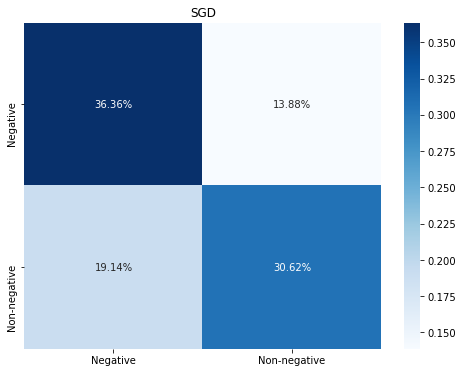

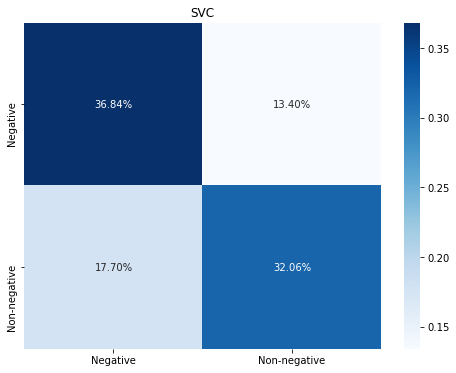

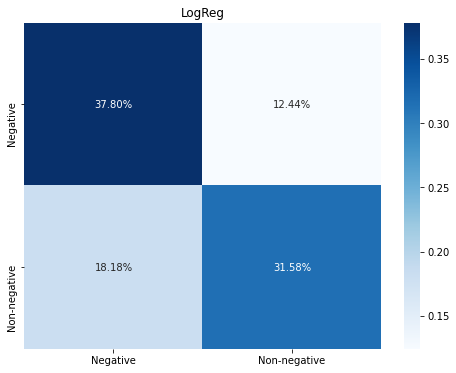

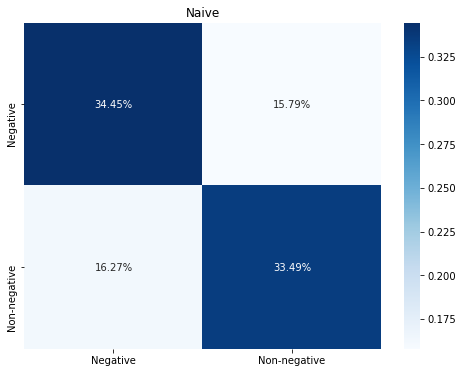

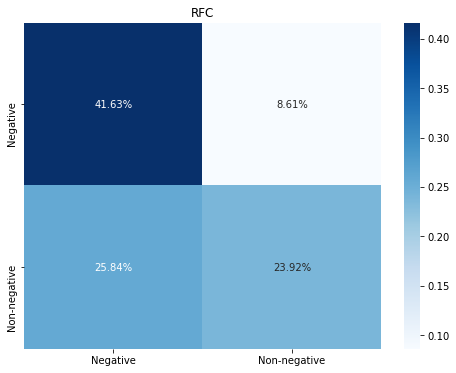

In [62]:
for key, model in models.items():

    model, cv_dict, y_pred = run_model(model, X_train, y_train, X_test, y_test, 5)
    model_perf[key] = {'Model': model, 'Performace': cv_dict}

    print(f'Showing results for: {key}')
    print(model_perf[key])
    print()

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))

    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
    ax.set_title(key);




In [63]:
y_test.value_counts()

0    105
1    104
Name: sentiment, dtype: int64

In [64]:
y_test.value_counts(normalize=True)

0    0.502392
1    0.497608
Name: sentiment, dtype: float64

## Tuned Models

In [65]:
sgd_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__loss': ['hinge','log','modified_huber','squared_hinge'],
    'clf__max_iter':[1000,2000],
    'clf__class_weight': [None, 'balanced']
}

svc_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__C': [1,5,10],
    'clf__kernel': ['linear','poly', 'rbf', 'sigmoid','precomputed'],
    'clf__degree': [3,6,9],
    'clf__gamma': ['auto', 'scale'],
    'clf__class_weight':[None, 'balanced']
}

lr_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__C': [1,5,10],
    'clf__solver': ['liblinear','lbfgs', 'sag', 'saga','newton-cg'],
    'clf__class_weight': ['balanced', None],
    'clf__multi_class': ['auto', 'ovr', 'multinomial'],
    'clf__penalty':['l1','l2','elasticnet', 'none']
}

nb_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False]
}

rf_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__n_estimators': [100,200,300,400,500],
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [1,3,5],
    'clf__class_weight': [None,'balanced', 'balanced_subsample']
}

In [66]:
def grid_run(estimator, est_params, X_train, y_train, X_test, y_test, cv, score='accuracy'):

  model, cv_dict, y_pred = run_model(estimator, X_train, y_train, X_test, y_test, cv)

  grid = GridSearchCV(model,param_grid= est_params, cv=cv, verbose=1, n_jobs=-3, scoring= score)
  grid = grid.fit(X_train, y_train)

  return(grid)

In [67]:
model_params = {'SGD':{sgd:sgd_params}, 'SVC': {svc:svc_params}, 'LogReg': {lr:lr_params}, 'Naive': {nb:nb_params}, 'RFC': {rf:rf_params}}

In [78]:
for key, estimators in model_params.items():
  for estimator, params in estimators.items():

    print('----------------------------------------------')
    print(f'Now running {key} GridSearch')

    grid = grid_run(estimator, params, X_train, y_train, X_test, y_test, 5, score='accuracy')

    print()
    print(grid.best_score_)
    print(grid.best_params_)
    print()

----------------------------------------------
Now running SGD GridSearch
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-3)]: Done 750 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-3)]: Done 2750 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-3)]: Done 2880 out of 2880 | elapsed:   18.7s finished



0.6656000000000001
{'clf__class_weight': 'balanced', 'clf__loss': 'hinge', 'clf__max_iter': 1000, 'tfidf__smooth_idf': True, 'vect__lowercase': True, 'vect__ngram_range': (1, 2), 'vect__strip_accents': None}

----------------------------------------------
Now running SVC GridSearch
Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-3)]: Done 620 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-3)]: Done 1620 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-3)]: Done 3020 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-3)]: Done 4820 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-3)]: Done 7020 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-3)]: Done 9620 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-3)]: Done 12620 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done 16020 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-3)]: Done 19820 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-3)]: Done 24020 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-3)]: Done 28620 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-3)]: Done 32381 out of 32400 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 32400 out of 32400 | elapsed:  3.6min finished



0.6704000000000001
{'clf__C': 5, 'clf__class_weight': None, 'clf__degree': 3, 'clf__gamma': 'auto', 'clf__kernel': 'linear', 'tfidf__smooth_idf': True, 'vect__lowercase': True, 'vect__ngram_range': (1, 2), 'vect__strip_accents': None}

----------------------------------------------
Now running LogReg GridSearch
Fitting 5 folds for each of 12960 candidates, totalling 64800 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-3)]: Done 800 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-3)]: Done 2800 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-3)]: Done 5120 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-3)]: Done 8622 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-3)]: Done 10440 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-3)]: Done 15280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done 21196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-3)]: Done 23950 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-3)]: Done 27840 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-3)]: Done 32260 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-3)]: Done 36876 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-3)]: Done 42570 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-3)]: Done 48426 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-3)]: Done 53680 


0.6608
{'clf__C': 5, 'clf__class_weight': 'balanced', 'clf__multi_class': 'auto', 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__smooth_idf': True, 'vect__lowercase': True, 'vect__ngram_range': (1, 1), 'vect__strip_accents': None}

----------------------------------------------
Now running Naive GridSearch
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-3)]: Done 180 out of 180 | elapsed:    0.8s finished



0.6464000000000001
{'tfidf__smooth_idf': False, 'vect__lowercase': True, 'vect__ngram_range': (1, 1), 'vect__strip_accents': None}

----------------------------------------------
Now running RFC GridSearch
Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-3)]: Done 430 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-3)]: Done 780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done 1230 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-3)]: Done 1780 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-3)]: Done 2430 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done 3180 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-3)]: Done 4030 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-3)]: Done 4980 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-3)]: Done 6030 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-3)]: Done 7180 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-3)]: Done 8430 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-3)]: Done 9780 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-3)]: Done 11230 tasks      


0.664
{'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'entropy', 'clf__max_depth': 1, 'clf__n_estimators': 500, 'tfidf__smooth_idf': True, 'vect__lowercase': True, 'vect__ngram_range': (1, 1), 'vect__strip_accents': None}



In [80]:
# {'clf__class_weight': None, 
# 'clf__loss': 'log', 
# 'clf__max_iter': 1000, 
# 'tfidf__smooth_idf': True, 
# 'vect__lowercase': True, 
# 'vect__ngram_range': (2, 2), 
# 'vect__strip_accents': None}

sgd = Pipeline(
    [   ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', class_weight='balanced', random_state=SEED))
    ])


sgd.fit(X_train, y_train)

cv_acc = round(np.mean(cross_val_score(sgd, X_train, y_train, cv= 5, scoring= 'accuracy')),4)
cv_rec = round(np.mean(cross_val_score(sgd, X_train, y_train, cv= 5, scoring= 'recall')),4)


y_pred = sgd.predict(X_test)

test_acc = round(accuracy_score(y_pred, y_test), 4)
test_rec = round(recall_score(y_pred, y_test), 4)

print(cv_acc, cv_rec)
print(test_acc, test_rec)

0.6656 0.6294
0.689 0.7053


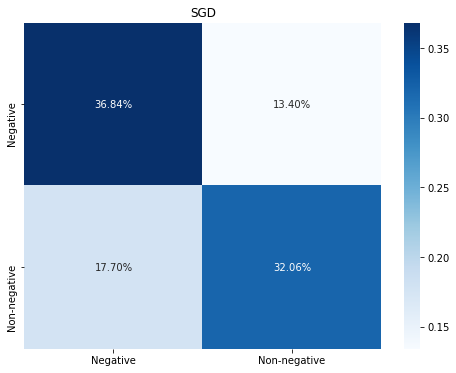

In [81]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
ax.set_title('SGD');

In [84]:
# {'clf__C': 1, 
# 'clf__class_weight': None, 
# 'clf__degree': 3, 
# 'clf__gamma': 'auto', 
# 'clf__kernel': 'poly', 
# 'tfidf__smooth_idf': True, 
# 'vect__lowercase': True, 
# 'vect__ngram_range': (1, 1), 
# 'vect__strip_accents': None}

svc = Pipeline(
    [   ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(C= 5, degree= 3, gamma= 'auto', kernel= 'linear', random_state=SEED))
    ])


svc.fit(X_train, y_train)

cv_acc = round(np.mean(cross_val_score(svc, X_train, y_train, cv= 5, scoring= 'accuracy')),4)
cv_rec = round(np.mean(cross_val_score(svc, X_train, y_train, cv= 5, scoring= 'recall')),4)


y_pred = svc.predict(X_test)

test_acc = round(accuracy_score(y_pred, y_test), 4)
test_rec = round(recall_score(y_pred, y_test), 4)

print(cv_acc, cv_rec)
print(test_acc, test_rec)

0.6704 0.6229
0.6699 0.6768


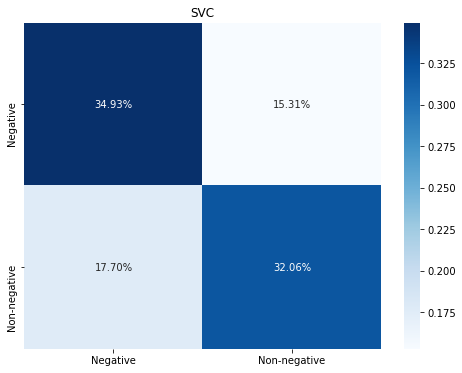

In [85]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
ax.set_title('SVC');